# Project Overview

I am working on analyzing a rich, multivariate dataset of transnational retail transactions from a UK-based non-store online retailer. The dataset contains over 540,000 instances, tracking transactions between December 2010 and December 2011. It includes key features such as invoice numbers, product descriptions, quantities sold, transaction dates, customer IDs, and countries of customer origin.

My goal is to develop a demand forecasting model that predicts product demand for the upcoming month. The forecasting model will be built using time-series analysis, leveraging trends and patterns from historical sales data to anticipate future product needs. The accuracy of the forecast will be critical in guiding inventory decisions, optimizing stock levels, and ensuring timely fulfillment for both wholesale and individual customers.

Throughout this project, I will be employing a variety of data preprocessing techniques, including handling sequential time-series data and transforming categorical variables. I aim to explore different machine learning models, including regression-based forecasting models, and validate their effectiveness to deliver a reliable 1-month ahead demand forecast.

https://archive.ics.uci.edu/dataset/352/online+retail

# Data Loading & Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
from google.colab import drive
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
!pip install prophet
from prophet import Prophet
import xgboost as xgb
!pip install pandas matplotlib statsmodels



# Setting the visual style for the plots to enhance readability on a dark background
plt.style.use('dark_background')
sns.set(style='darkgrid')
sns.set_palette('pastel')

# Configuring font properties for better visibility
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['text.color'] = 'white'  # Ensure text color contrasts with dark background

def set_plot_style():
    # Function to apply consistent styling to all plots
    sns.set_style('darkgrid', {'axes.facecolor': '#383838', 'figure.facecolor': '#383838'})

    # Setting context for plots to adjust scale and appearance
    sns.set_context("notebook", font_scale=0.8)

    # Choosing a dark color palette for all visualizations
    sns.set_palette('dark')

    # Defining default figure size for consistency
    plt.rcParams['figure.figsize'] = [8, 6]

    # Setting text color for various plot components
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['text.color'] = 'white'

# Apply the plot style function to all visualizations in the notebook
set_plot_style()

# Suppressing warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
# Mounting Google Drive to access files stored there
drive.mount('/content/drive')

def load_and_clean_data(file_path):
    # Function to load the dataset from the specified Excel file
    df = pd.read_excel(file_path)
    return df

# Specifying the path to the dataset
file_path = '/content/drive/My Drive/datasets/Online Retail.xlsx'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = load_and_clean_data(file_path)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


25% of our data has no customer ID, it is safe to say that customer-level analysis will not be our goal

In [ ]:
# Fill missing CustomerID with a placeholder value (0) to avoid losing important information
df['CustomerID'] = df['CustomerID'].fillna(0)

# Fill missing descriptions with a placeholder ('No Description') to maintain data integrity
df['Description'] = df['Description'].fillna('No Description')


# Exploratory Data Analysis (EDA)

## Generral Overview

In [ ]:
# Summary statistics for numerical columns
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,11476.974671
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,0.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,12352.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,14382.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16255.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,6777.908326




*   The minimum and max value for Quantity is +-80,995, which is likely a data entry error. This needs to be investigated and possibly corrected or removed from the dataset.

*  25% of the transactions have a quantity of 1, suggesting a large proportion of single-item orders.

*  50% of the transactions have a quantity of 3 or fewer, indicating that most orders are relatively small.

* The std is 218.08, indicating significant variability in the Quantity values





In [ ]:
# Calculate the Interquartile Range (IQR) for Quantity to identify outliers
Q1_quantity = df['Quantity'].quantile(0.25)
Q3_quantity = df['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

# Define outlier bounds for Quantity based on IQR
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

# Identify outliers in Quantity and count them
outliers_quantity = df[(df['Quantity'] < lower_bound_quantity) | (df['Quantity'] > upper_bound_quantity)]
num_outliers_quantity = outliers_quantity.shape[0]

# Calculate the Interquartile Range (IQR) for UnitPrice to identify outliers
Q1_price = df['UnitPrice'].quantile(0.25)
Q3_price = df['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Define outlier bounds for UnitPrice based on IQR
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

# Identify outliers in UnitPrice and count them
outliers_price = df[(df['UnitPrice'] < lower_bound_price) | (df['UnitPrice'] > upper_bound_price)]
num_outliers_price = outliers_price.shape[0]

# Output the counts of outliers for Quantity and UnitPrice
num_outliers_quantity, num_outliers_price


(58619, 39627)

In [ ]:
# Calculate the minimum and maximum values of outliers in Quantity
quantity_outlier_min = outliers_quantity['Quantity'].min()
quantity_outlier_max = outliers_quantity['Quantity'].max()

# Calculate the minimum and maximum values of outliers in UnitPrice
price_outlier_min = outliers_price['UnitPrice'].min()
price_outlier_max = outliers_price['UnitPrice'].max()

# Define the ranges for Quantity and UnitPrice outliers
quantity_outlier_range = (quantity_outlier_min, quantity_outlier_max)
price_outlier_range = (price_outlier_min, price_outlier_max)

# Output the ranges for both Quantity and UnitPrice outliers
quantity_outlier_range, price_outlier_range


((-80995, 80995), (-11062.06, 38970.0))

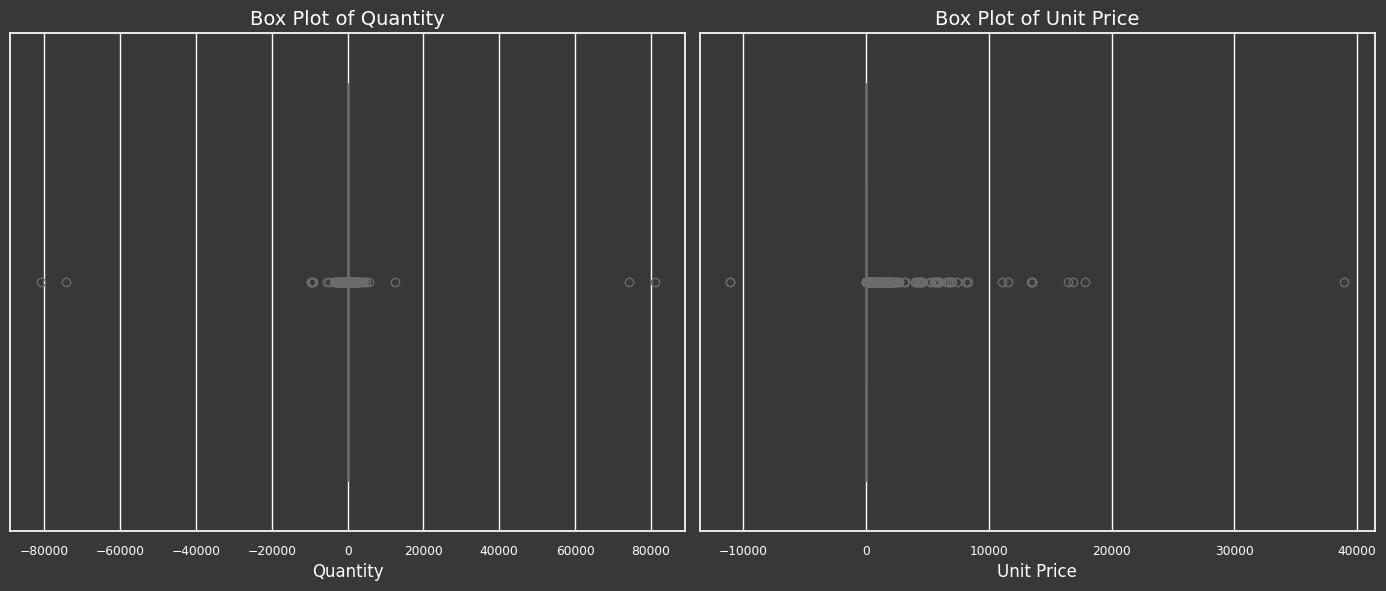

In [ ]:
# Set up the figure size for the box plots
plt.figure(figsize=(14, 6))

# Create a box plot for Quantity
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Quantity'], color='#66b3ff')  # Box plot for Quantity with a light blue color
plt.title('Box Plot of Quantity', fontsize=14, color='white')  # Title for Quantity plot
plt.xlabel('Quantity', fontsize=12, color='white')  # X-axis label for Quantity plot
plt.ylabel('')  # Remove Y-axis label for clarity

# Create a box plot for Unit Price
plt.subplot(1, 2, 2)
sns.boxplot(x=df['UnitPrice'], color='#66b3ff')  # Box plot for Unit Price with the same color
plt.title('Box Plot of Unit Price', fontsize=14, color='white')  # Title for Unit Price plot
plt.xlabel('Unit Price', fontsize=12, color='white')  # X-axis label for Unit Price plot

# Adjust layout to prevent overlap and show the plots
plt.tight_layout()
plt.show()


To clean the data, we're converting negative Quantity and UnitPrice values to positive since they likely represent returns or errors. For outliers above the 95th percentile, we're reducing their impact by scaling them down by dividing by 10, ensuring they don’t skew the model while keeping them in the dataset.


In [ ]:
# Convert all negative values in Quantity and UnitPrice to positive
df['Quantity'] = df['Quantity'].abs()  # Use absolute values for Quantity
df['UnitPrice'] = df['UnitPrice'].abs()  # Use absolute values for Unit Price

# Calculate the 95th percentile for Quantity and Unit Price
q_95 = df['Quantity'].quantile(0.95)  # 95th percentile for Quantity
u_95 = df['UnitPrice'].quantile(0.95)  # 95th percentile for Unit Price

# Scale down values that exceed the 95th percentile
df.loc[df['Quantity'] > q_95, 'Quantity'] /= 10  # Reduce Quantity values above the 95th percentile
df.loc[df['UnitPrice'] > u_95, 'UnitPrice'] /= 10  # Reduce Unit Price values above the 95th percentile


In [ ]:
# Display summary statistics for Quantity and UnitPrice after data cleaning and scaling
df[['Quantity', 'UnitPrice']].describe()  # Summary statistics to assess the impact of data cleaning


,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,6.175068,2.786473
std,22.571949,9.871322
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,1.950000
75%,10.000000,3.750000
max,8099.500000,3897.000000


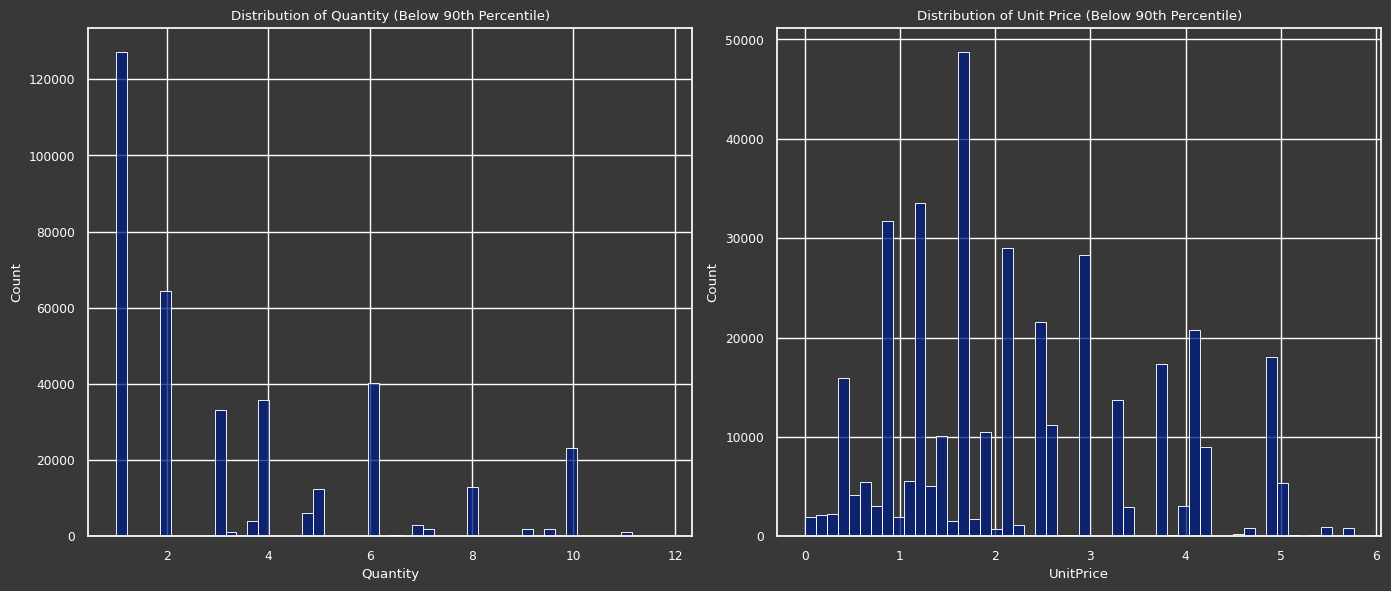

In [ ]:
# Calculate the 90th percentile for Quantity and UnitPrice
quantity_90th_percentile = df['Quantity'].quantile(0.90)  # Determine the threshold for the top 10% in Quantity
unit_price_90th_percentile = df['UnitPrice'].quantile(0.90)  # Determine the threshold for the top 10% in Unit Price

# Filter the DataFrame to keep only data points below the 90th percentile
df_filtered = df[(df['Quantity'] < quantity_90th_percentile) & (df['UnitPrice'] < unit_price_90th_percentile)]  # Exclude top 10% of values

# Set up the plots for Quantity and UnitPrice distribution
plt.figure(figsize=(14, 6))  # Create a figure with specified size

# Histogram for Quantity
plt.subplot(1, 2, 1)  # Create the first subplot for Quantity
sns.histplot(df_filtered['Quantity'], bins=50)  # Plot the histogram for Quantity
plt.title('Distribution of Quantity (Below 90th Percentile)')  # Set title for Quantity histogram

# Histogram for Unit Price
plt.subplot(1, 2, 2)  # Create the second subplot for Unit Price
sns.histplot(df_filtered['UnitPrice'], bins=50)  # Plot the histogram for Unit Price
plt.title('Distribution of Unit Price (Below 90th Percentile)')  # Set title for Unit Price histogram

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display the plots


In [ ]:
# Convert InvoiceDate to datetime format for easier manipulation
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Ensure InvoiceDate is in datetime format

# Extract the date from InvoiceDate to group sales by day
df['Date'] = df['InvoiceDate'].dt.date  # Create a new column 'Date' with just the date part

# Aggregate total quantity sold by date
daily_sales = df.groupby('Date').agg({'Quantity': 'sum'}).reset_index()  # Group by 'Date' and sum the 'Quantity'

# Rename the columns for clarity
daily_sales.columns = ['Date', 'Total_Quantity_Sold']  # Update column names to be more descriptive

# Set the date as the index for time series analysis
daily_sales.set_index('Date', inplace=True)  # Set 'Date' as the index of the DataFrame

# Display the first few rows of the daily sales data to verify the results
daily_sales.head()  # Show the first few entries in the daily sales DataFrame


,Total_Quantity_Sold
Date,
2010-12-01,15528.8
2010-12-02,16215.6
2010-12-03,10886.8
2010-12-05,12115.0
2010-12-06,16198.3


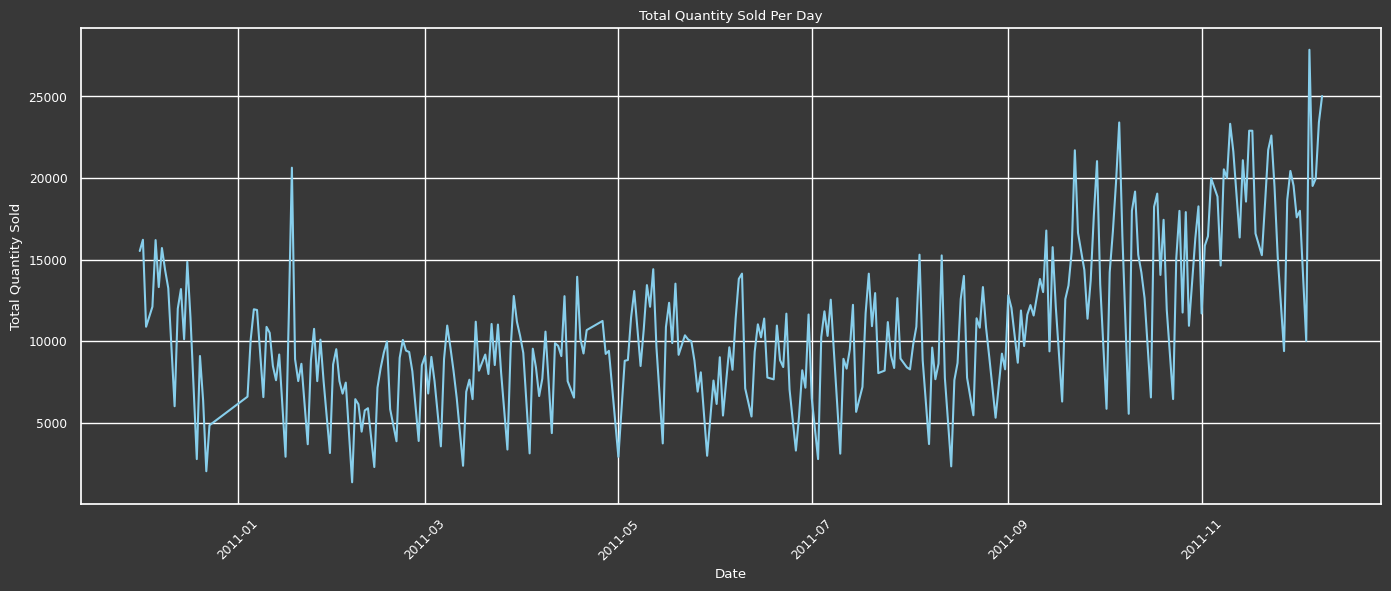

In [ ]:
# Plot the daily sales data
plt.figure(figsize=(14, 6))  # Set the figure size for the plot
plt.plot(daily_sales.index, daily_sales['Total_Quantity_Sold'], color='skyblue')  # Plot total quantity sold against date

# Set plot title and labels
plt.title('Total Quantity Sold Per Day')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Total Quantity Sold')  # Label for the y-axis

# Rotate x-ticks for better readability
plt.xticks(rotation=45)  # Rotate the date labels on the x-axis

plt.tight_layout()  # Adjust the layout to prevent clipping of tick-labels
plt.show()  # Display the plot


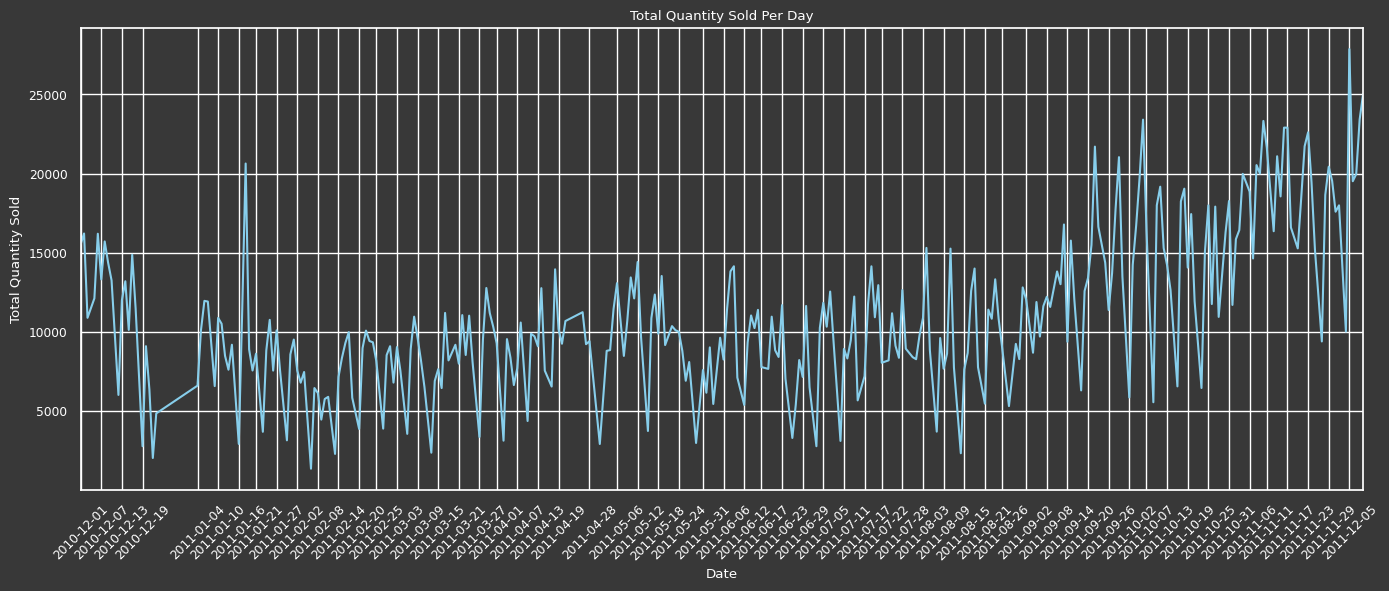

In [ ]:
# Plot the daily sales data
plt.figure(figsize=(14, 6))  # Set the figure size for better visibility
plt.plot(daily_sales.index, daily_sales['Total_Quantity_Sold'], color='skyblue')  # Plot total quantity sold against date

# Set the title and labels for the plot
plt.title('Total Quantity Sold Per Day')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Total Quantity Sold')  # Label for the y-axis

# Configure x-axis to display every 5th date for better readability
plt.xticks(daily_sales.index[::5], rotation=45)  # Rotate the date labels for clarity
plt.xlim(daily_sales.index.min(), daily_sales.index.max())  # Set limits for the x-axis

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()  # Display the plot


# Feature Engineering & Data Review

## Data Review

In [ ]:
daily_sales.index = pd.to_datetime(daily_sales.index)

# Create new date-related features for better analysis and model performance
# 1. Day of the week: This feature indicates which day of the week the sale occurred
daily_sales['Day of Week'] = daily_sales.index.dayofweek  # 0=Monday, 6=Sunday

# 2. Month: Extracts the month from the date, which can help identify seasonal patterns
daily_sales['Month'] = daily_sales.index.month  # 1-12

# 3. Year: This feature is useful for understanding trends over different years
daily_sales['Year'] = daily_sales.index.year  # Extract year

# 4. Is Weekend: A binary feature indicating whether the sale occurred on a weekend (1 for Saturday/Sunday, 0 otherwise)
daily_sales['Is Weekend'] = daily_sales['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)  # 1 if Saturday/Sunday

# Display the updated DataFrame with new features to verify changes
print(daily_sales.head())


            Total_Quantity_Sold  Day of Week  Month  Year  Is Weekend
Date                                                                 
2010-12-01              15528.8            2     12  2010           0
2010-12-02              16215.6            3     12  2010           0
2010-12-03              10886.8            4     12  2010           0
2010-12-05              12115.0            6     12  2010           1
2010-12-06              16198.3            0     12  2010           0


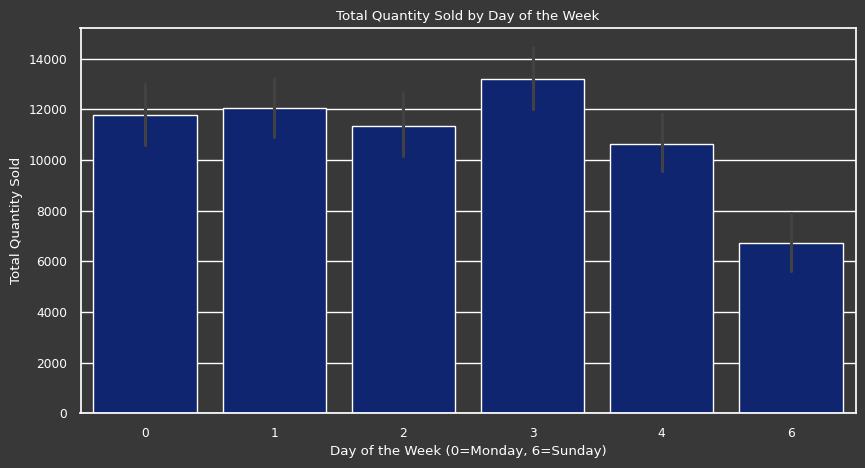

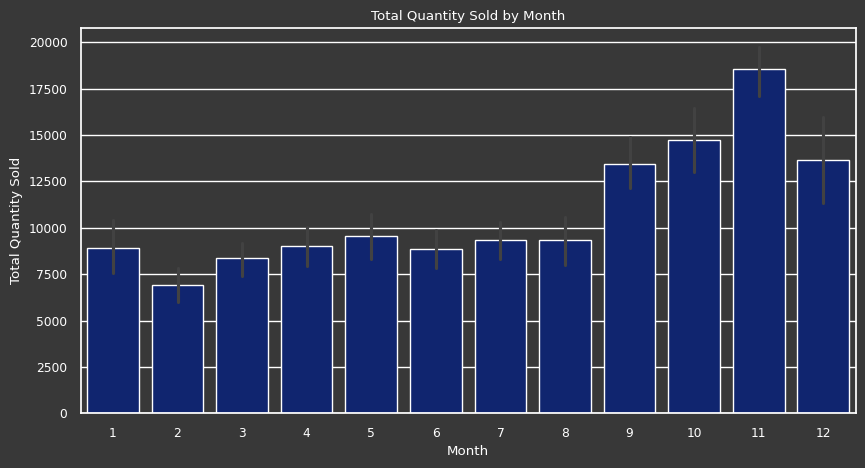

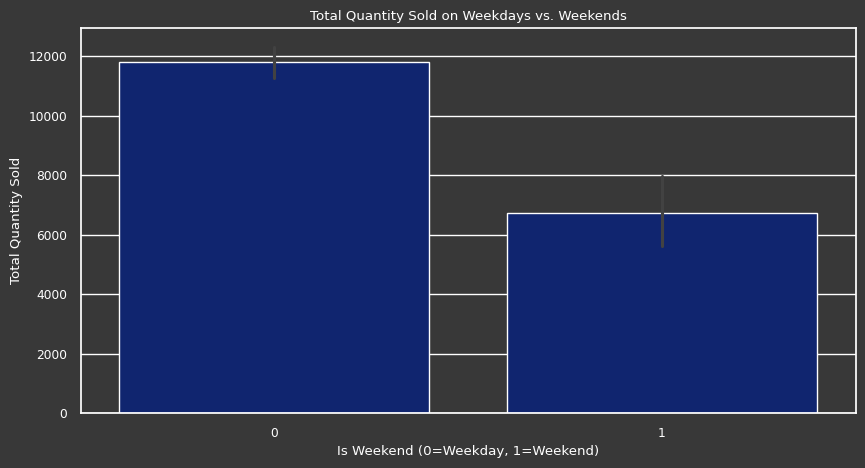

In [ ]:

set_plot_style()

# Plot Sales by Day of the Week
plt.figure(figsize=(10, 5))
sns.barplot(x='Day of Week', y='Total_Quantity_Sold', data=daily_sales.reset_index())
plt.title('Total Quantity Sold by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.show()

# Plot Sales by Month
plt.figure(figsize=(10, 5))
sns.barplot(x='Month', y='Total_Quantity_Sold', data=daily_sales.reset_index())
plt.title('Total Quantity Sold by Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.show()

# Plot Sales by Is Weekend
plt.figure(figsize=(10, 5))
sns.barplot(x='Is Weekend', y='Total_Quantity_Sold', data=daily_sales.reset_index())
plt.title('Total Quantity Sold on Weekdays vs. Weekends')
plt.xlabel('Is Weekend (0=Weekday, 1=Weekend)')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.show()


Our analysis reveals two key insights regarding sales patterns:

1. **Weekend Demand**: Sales drop significantly on weekends, falling from **11,000 to 13,000 units** on weekdays to about **6,500 to 10,500 units**. This suggests a need to adjust marketing and inventory strategies for weekends.

2. **Monthly Demand Trends**: Demand is lower in the first eight months, averaging **7,500 to 9,000 units**, but increases sharply in the last four months to **13,000 to 18,500 units**. This indicates seasonal influences, likely due to holiday shopping.

**Next Steps**

To leverage these insights:

- **Feature Engineering**: Add features for the day of the week and month to improve model accuracy.
  
- **Model Refinement**: Experiment with models that better capture seasonality and trends.

- **Marketing Strategies**: Align marketing efforts and inventory management with the identified peak sales periods.

Implementing these steps should enhance our forecasting capabilities and improve overall sales performance.


## Feature Engineering

In [ ]:
# Create lagged features

for lag in range(1, 8):  # Creating lagged features for the past week
    data[f'Lag_{lag}'] = data['Total_Quantity_Sold'].shift(lag)

# Create moving averages
data['Moving_Avg_7'] = data['Total_Quantity_Sold'].rolling(window=7).mean()
data['Moving_Avg_30'] = data['Total_Quantity_Sold'].rolling(window=30).mean()

# Create a holiday indicator (for example, assuming December is a holiday month)
data['Is_Holiday'] = data.index.month == 12  # Change as necessary

# Drop rows with NaN values generated by shifting and rolling
data.dropna(inplace=True)

# Display the updated DataFrame
data.head()


,Total_Quantity_Sold,Day of Week,Month,Year,Is Weekend,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Moving_Avg_7,Moving_Avg_30,Is_Holiday
Date,,,,,,,,,,,,,,,
2011-02-17,9987.2,3,2,2011,0,9297.5,8353.1,7152.8,2291.2,5895.8,5759.6,4459.5,6962.457143,7595.810000,False
2011-02-18,5836.0,4,2,2011,0,9987.2,9297.5,8353.1,7152.8,2291.2,5895.8,5759.6,6973.371429,7484.116667,False
2011-02-20,3871.4,6,2,2011,1,5836.0,9987.2,9297.5,8353.1,7152.8,2291.2,5895.8,6684.171429,7515.763333,False
2011-02-21,8975.3,0,2,2011,0,3871.4,5836.0,9987.2,9297.5,8353.1,7152.8,2291.2,7639.042857,7435.370000,False
2011-02-22,10079.1,1,2,2011,0,8975.3,3871.4,5836.0,9987.2,9297.5,8353.1,7152.8,8057.085714,7083.533333,False


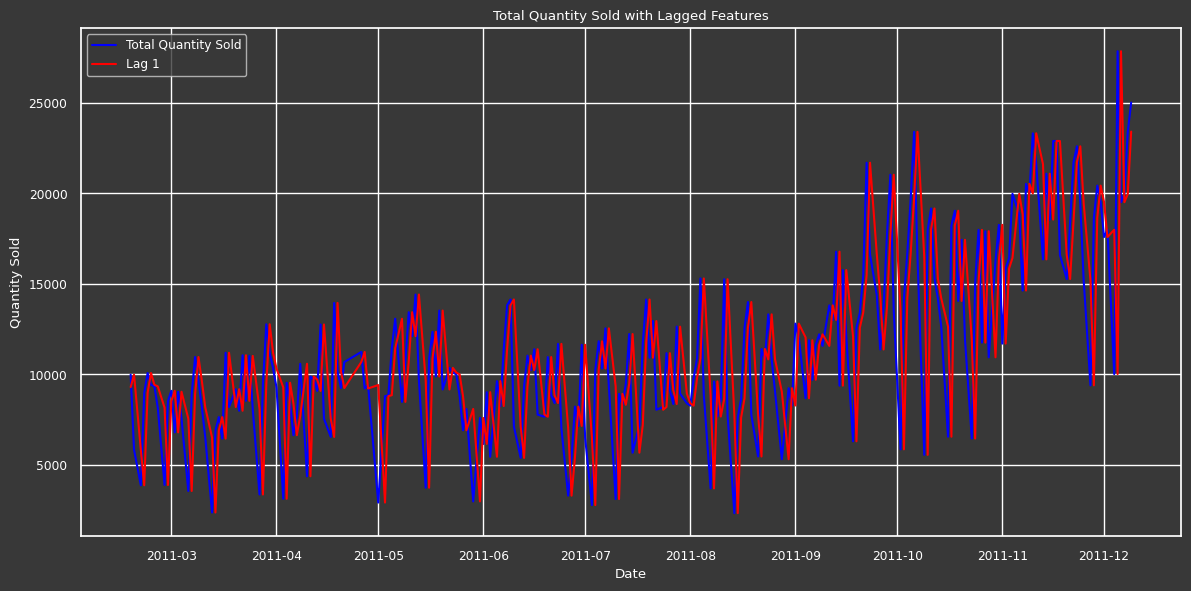

In [ ]:
# Plotting sales data with lagged features
plt.figure(figsize=(12, 6))
plt.plot(data['Total_Quantity_Sold'], label='Total Quantity Sold', color='blue')
plt.plot(data['Lag_1'], label='Lag 1', color='red')
plt.title('Total Quantity Sold with Lagged Features')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.tight_layout()
plt.show()

Lag 1 closely mirrors the behavior of the Total Quantity Sold, indicating that immediate past sales significantly influence current sales figures.

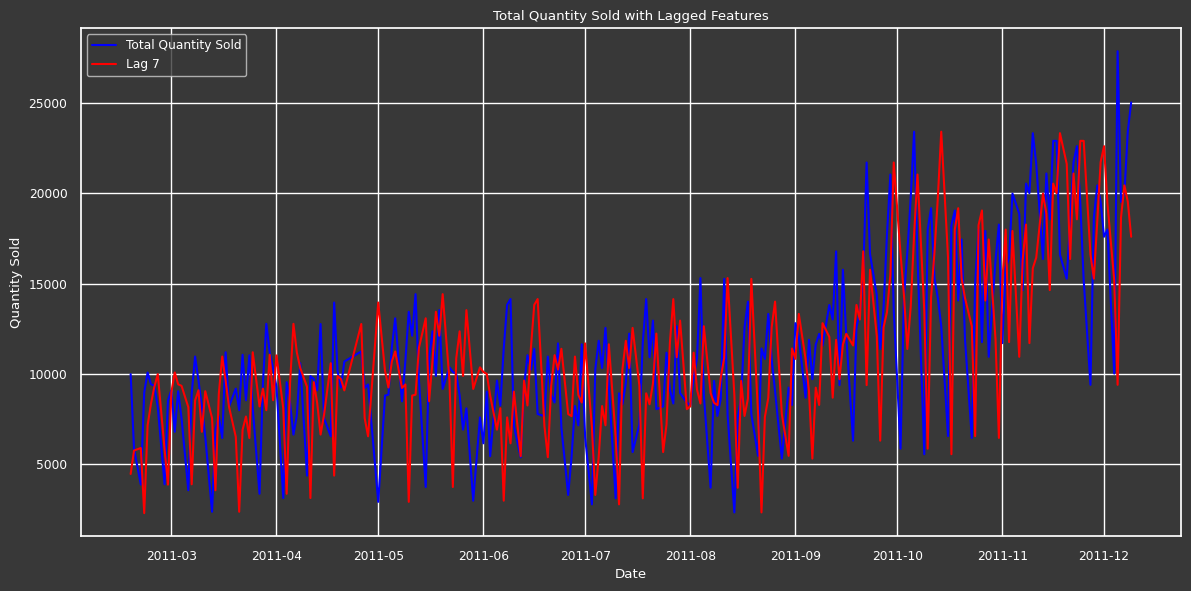

In [ ]:
# Plotting sales data with lagged features
plt.figure(figsize=(12, 6))
plt.plot(data['Total_Quantity_Sold'], label='Total Quantity Sold', color='blue')
plt.plot(data['Lag_7'], label='Lag 7', color='red')
plt.title('Total Quantity Sold with Lagged Features')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.tight_layout()
plt.show()

Lag 7 shows a delayed pattern, suggesting that sales from a week prior still affect today's sales, which highlights the persistence of consumer purchasing behavior.

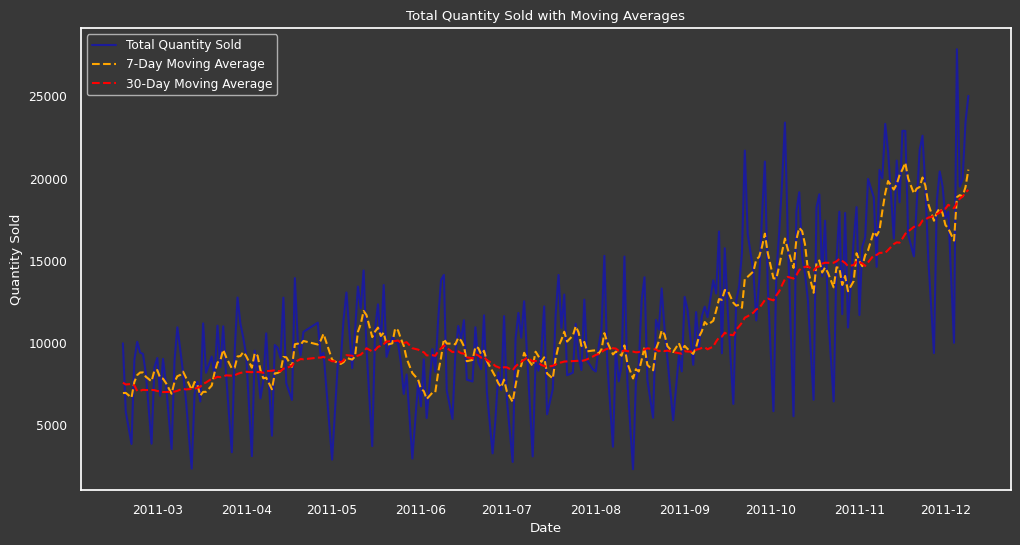

In [ ]:
# Plotting Total Quantity Sold with Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(data['Total_Quantity_Sold'], label='Total Quantity Sold', color='blue', alpha=0.5)
plt.plot(data['Moving_Avg_7'], label='7-Day Moving Average', color='orange', linestyle='--')
plt.plot(data['Moving_Avg_30'], label='30-Day Moving Average', color='red', linestyle='--')
plt.title('Total Quantity Sold with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid()
plt.show()


Both the 7-Day Moving Average and 30-Day Moving Average closely track the Total Quantity Sold, with the 7-Day Moving Average providing a more responsive and accurate reflection of recent trends.

# Demand Forecasting Models

In [ ]:
def split_data_linear_reg(data, target_column='Total_Quantity_Sold', test_size=0.2):
    """
    Splits the data for linear regression.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data to split.
    - target_column (str): The name of the target variable column.
    - test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    - X_train_linear, X_test_linear (np.ndarray): Feature sets for training and testing.
    - y_train_linear, y_test_linear (np.ndarray): Target variables for training and testing.
    """
    # Ensure the target column is in the DataFrame
    if target_column not in data.columns:
        raise KeyError(f"'{target_column}' not found in DataFrame columns.")

    # Convert date index to ordinal numbers for features (X)
    X_linear = data.index.to_series().apply(lambda x: x.toordinal()).values.reshape(-1, 1)

    # Define target variable (y)
    y_linear = data[target_column].values  # Target variable

    # Ensure the lengths of X and y are the same
    assert len(X_linear) == len(y_linear), "X and y must have the same length."

    # Split the dataset into training and testing sets (keeping time series order)
    X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
        X_linear, y_linear, test_size=test_size, shuffle=False
    )

    return X_train_linear, X_test_linear, y_train_linear, y_test_linear

In [ ]:
def split_data(data):
    """
    Splits the data into training and testing sets using predefined settings.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data to split.

    Returns:
    - X_train, X_test (pd.DataFrame): Feature sets for training and testing.
    - y_train, y_test (pd.Series): Target variables for training and testing.
    """
    target_column = 'Total_Quantity_Sold'  # Hardcoded target column
    test_size = 30  # Hardcoded test size

    # Ensure the target column is in the DataFrame
    if target_column not in data.columns:
        raise KeyError(f"'{target_column}' not found in DataFrame columns.")

    # Define features (X) and target variable (y)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Split the data into training and testing sets
    train_size = len(data) - test_size  # Calculate the train size based on the test size
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test



Split before feature engineering

In [ ]:
X_train_linear, X_test_linear, y_train_linear, y_test_linear = split_data_linear_reg(daily_sales)
X_train, X_test, y_train, y_test = split_data(daily_sales)

Split After feature engineering

In [ ]:
X_train_linear, X_test_linear, y_train_linear, y_test_linear = split_data_linear_reg(data)
X_train, X_test, y_train, y_test = split_data(data)

## ARIMA

An ARIMA (AutoRegressive Integrated Moving Average) model was applied to forecast total quantities sold for the following 30 days. This model is well-suited for time series forecasting, capturing both trends and seasonality.

In [ ]:
def arima_forecast(data):
    # Check if 'Total_Quantity_Sold' column exists in the DataFrame
    if 'Total_Quantity_Sold' not in data.columns:
        raise ValueError("DataFrame must contain a 'Total_Quantity_Sold' column.")

    # Fit the ARIMA model to the historical daily sales data from the DataFrame
    model = ARIMA(data['Total_Quantity_Sold'], order=(5, 1, 0))
    model_fit = model.fit()  # Fit the model to the data

    # Forecast future sales for the next 30 days
    forecast = model_fit.forecast(steps=30)  # Generate the forecast for the next 30 days

    # Create a date range for the forecasted values
    last_date = data.index[-1]  # Get the last date from the historical data in the DataFrame
    forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)  # Create a date range for the forecast
    forecast_series = pd.Series(forecast.values, index=forecast_dates)  # Create a Series for forecast values with the new date index

    # Plot the historical data and the forecasted values
    plt.figure(figsize=(14, 6))  # Set figure size for clarity
    plt.plot(data.index, data['Total_Quantity_Sold'], label='Historical Data', color='blue')  # Historical data
    plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red', linestyle='--')  # Forecasted data

    # Set x-axis limits to show both historical and forecast data
    plt.xlim(data.index.min(), forecast_series.index.max())  # Ensure x-axis covers both datasets

    # Set title and labels for the plot
    plt.title('Total Quantity Sold with ARIMA Forecast', fontsize=16)  # Title for the plot
    plt.xlabel('Date', fontsize=12)  # X-axis label
    plt.ylabel('Total Quantity Sold', fontsize=12)  # Y-axis label
    plt.legend()  # Show legend for clarity
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()  # Display the plot

    # Forecast for the same length as the test set
    n_test = len(y_test)  # Number of test samples
    arima_forecast = model_fit.forecast(steps=n_test)  # Generate the forecast for the test set

    # Calculate MAE and RMSE
    mae_arima = mean_absolute_error(y_test, arima_forecast)
    rmse_arima = mean_squared_error(y_test, arima_forecast, squared=False)

    print(f"ARIMA Mean Absolute Error (MAE): {mae_arima:.2f}")
    print(f"ARIMA Root Mean Squared Error (RMSE): {rmse_arima:.2f}")
    return mae_arima, rmse_arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


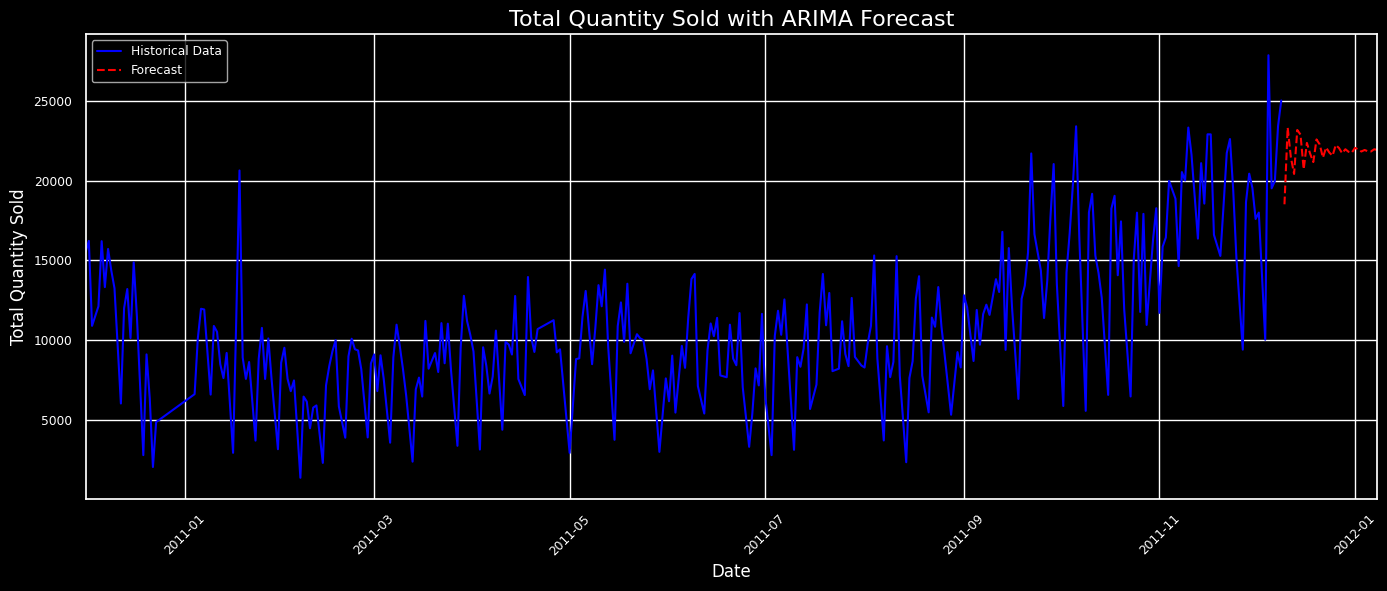

ARIMA Mean Absolute Error (MAE): 3430.73
ARIMA Root Mean Squared Error (RMSE): 4660.32


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
mae_arima, rmse_arima = arima_forecast(daily_sales)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


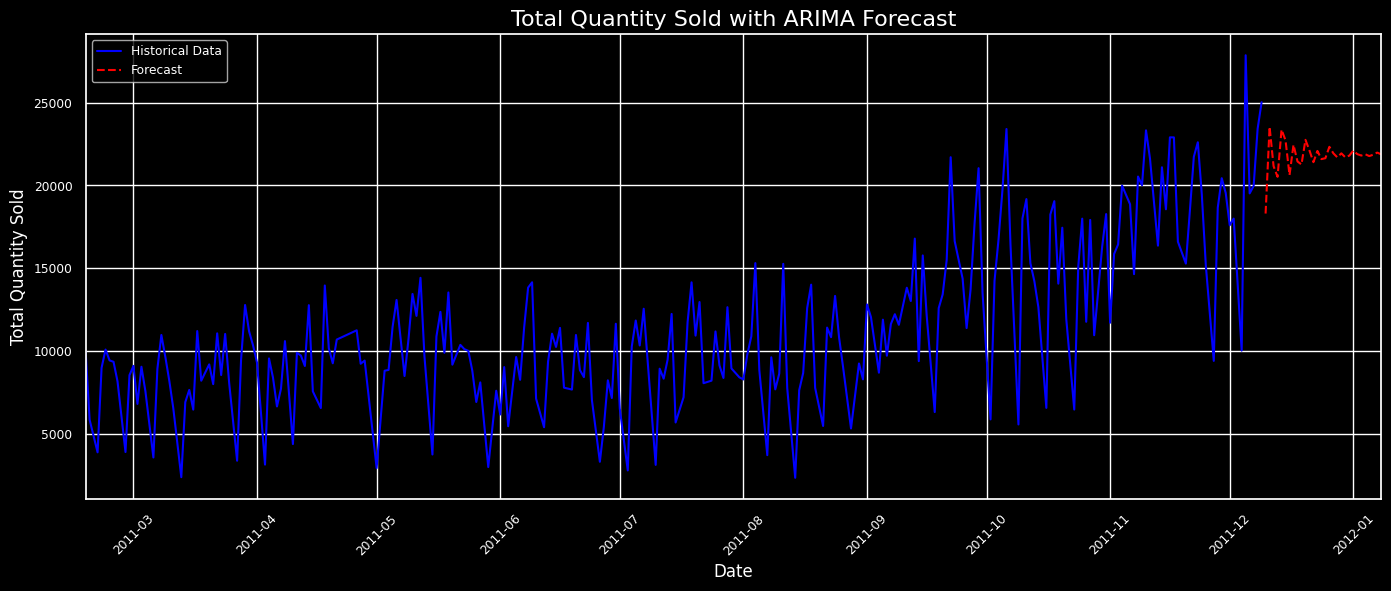

ARIMA Mean Absolute Error (MAE): 3402.16
ARIMA Root Mean Squared Error (RMSE): 4647.63


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
mae_arima, rmse_arima = arima_forecast(data)

## Linear Regression

Mean Absolute Error (MAE): 5203.17
Root Mean Squared Error (RMSE): 5990.44


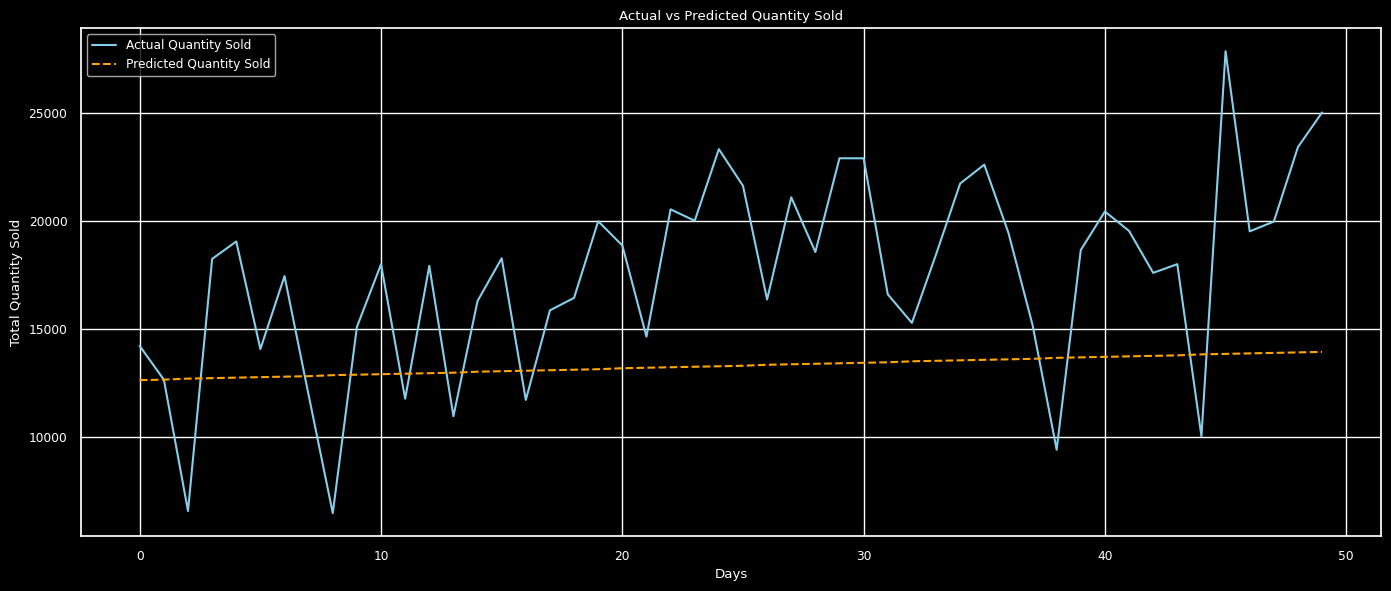

In [ ]:
# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_linear, y_train_linear)

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test_linear)

# Evaluate the model
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)
rmse_linear = mean_squared_error(y_test_linear, y_pred_linear, squared=False)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae_linear:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_linear:.2f}")

# Plotting actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_linear, label='Actual Quantity Sold', color='skyblue')
plt.plot(y_pred_linear, label='Predicted Quantity Sold', color='orange', linestyle='--')
plt.title('Actual vs Predicted Quantity Sold')
plt.xlabel('Days')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Decomposition of Time Series (STL) with Exponential Smoothing

In [ ]:
def stl_forecast(data):
    # Check if 'Total_Quantity_Sold' column exists in the DataFrame
    if 'Total_Quantity_Sold' not in data.columns:
        raise ValueError("DataFrame must contain a 'Total_Quantity_Sold' column.")

    # Decompose the time series and fit the Exponential Smoothing model
    model_stl = ExponentialSmoothing(data['Total_Quantity_Sold'],
                                      trend='add',
                                      seasonal='add',
                                      seasonal_periods=30).fit()

    # Forecast for the next 30 days
    stl_forecast = model_stl.forecast(steps=30)

    # Create a proper date index for the forecast
    last_date = data.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    stl_forecast.index = forecast_dates

    # Plotting the results
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data['Total_Quantity_Sold'], label='Historical Data', color='skyblue')
    plt.plot(stl_forecast.index, stl_forecast, label='STL Forecast', color='orange', linestyle='--')
    plt.title('Total Quantity Sold with STL Exponential Smoothing Forecast', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Quantity Sold', fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Evaluating the STL model
    actual_values = data['Total_Quantity_Sold'][-30:]  # Last 30 days for evaluation
    mae_stl = mean_absolute_error(actual_values, stl_forecast)
    rmse_stl = mean_squared_error(actual_values, stl_forecast, squared=False)

    print(f"STL Model Mean Absolute Error (MAE): {mae_stl:.2f}")
    print(f"STL Model Root Mean Squared Error (RMSE): {rmse_stl:.2f}")
    return mae_stl, rmse_stl

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


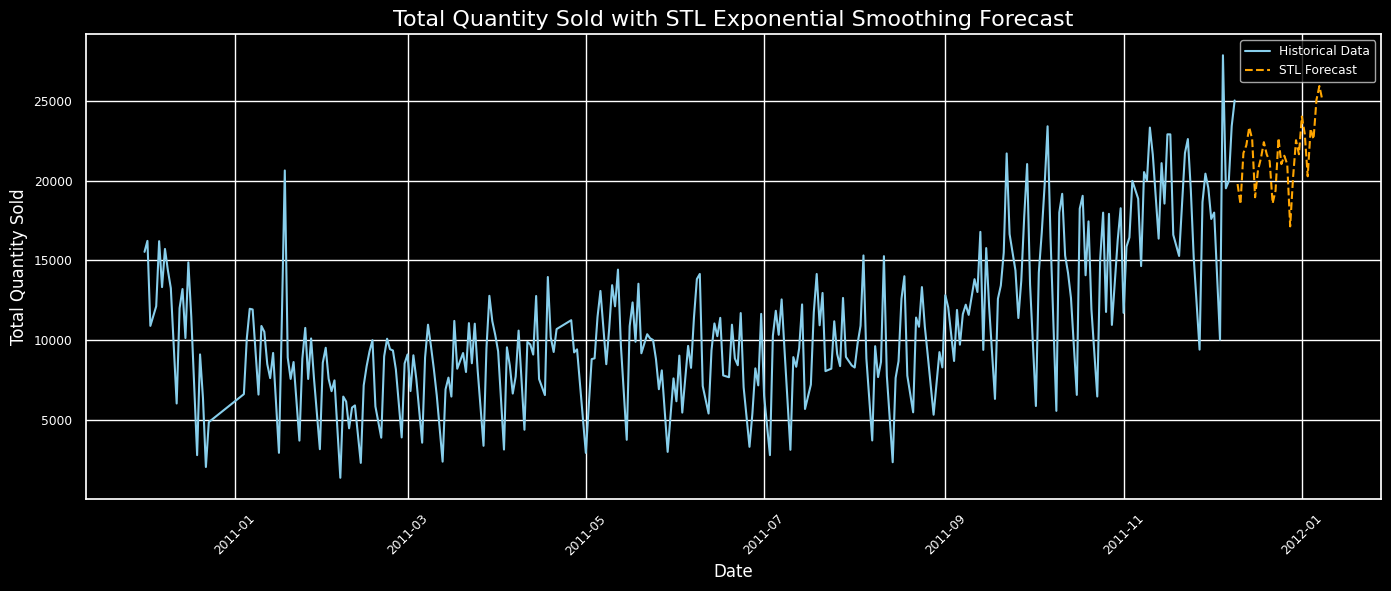

STL Model Mean Absolute Error (MAE): 2885.22
STL Model Root Mean Squared Error (RMSE): 3740.56


In [ ]:
mae_stl, rmse_stl = stl_forecast(daily_sales)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


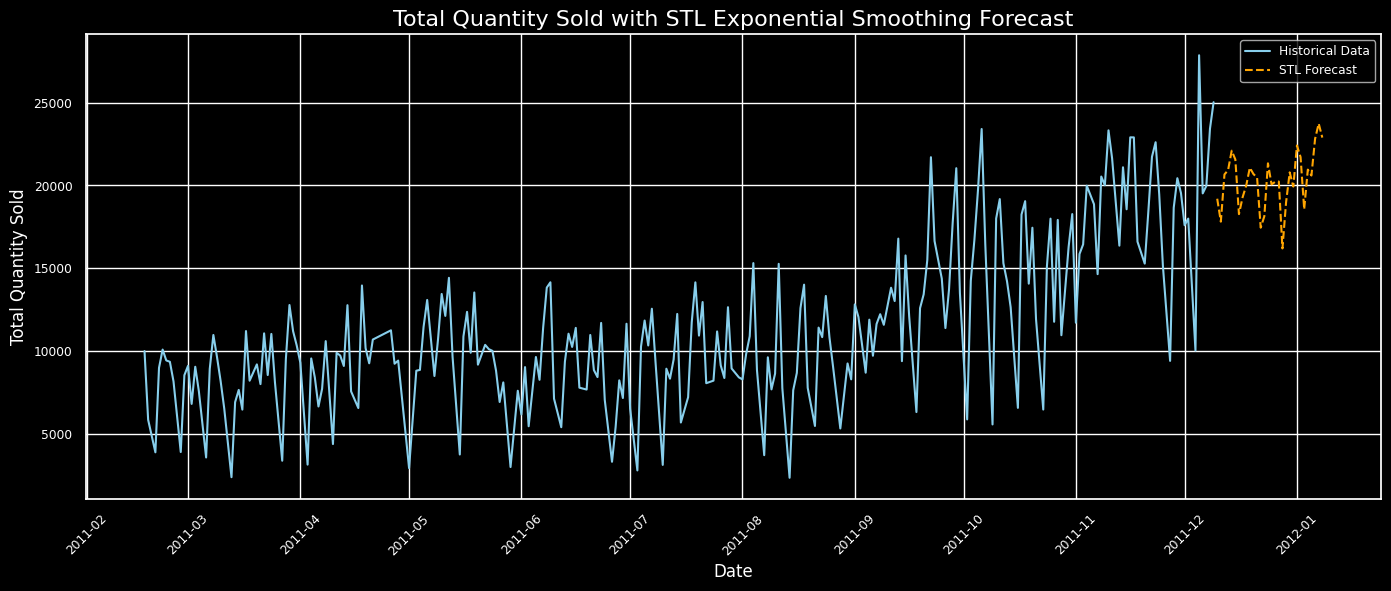

STL Model Mean Absolute Error (MAE): 2278.84
STL Model Root Mean Squared Error (RMSE): 3164.73


In [ ]:
mae_stl, rmse_stl = stl_forecast(data)

## XgBoost [TODO]

XGBoost Model Mean Absolute Error (MAE): 6015.57
XGBoost Model Root Mean Squared Error (RMSE): 6893.25


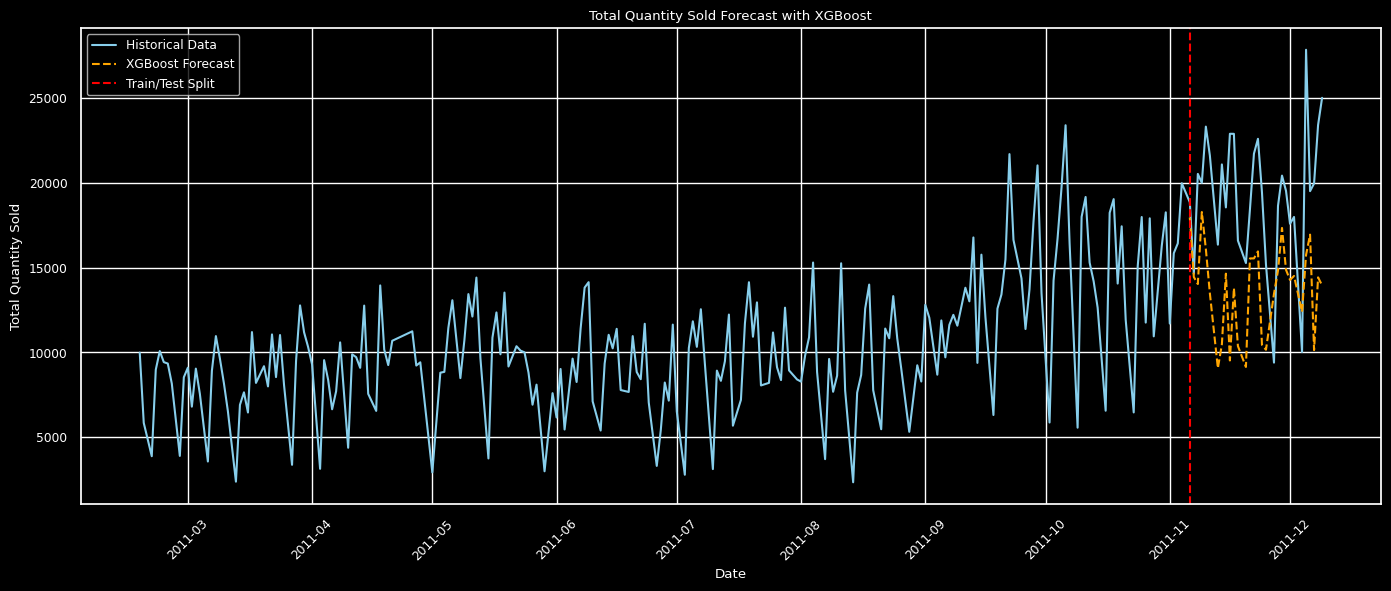

In [ ]:
# Initialize XGBoost regressor model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)

# Print evaluation metrics
print(f"XGBoost Model Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"XGBoost Model Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")

# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Total_Quantity_Sold'], label='Historical Data', color='skyblue')
plt.plot(data.index[train_size:], y_pred, label='XGBoost Forecast', color='orange', linestyle='--')
plt.axvline(x=data.index[train_size], color='red', linestyle='--', label='Train/Test Split')
plt.title('Total Quantity Sold Forecast with XGBoost')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Prophet


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbp8p7cy/gukypi6q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbp8p7cy/vc00q6n_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45302', 'data', 'file=/tmp/tmpbbp8p7cy/gukypi6q.json', 'init=/tmp/tmpbbp8p7cy/vc00q6n_.json', 'output', 'file=/tmp/tmpbbp8p7cy/prophet_model3r6h0_uk/prophet_model-20241011172912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


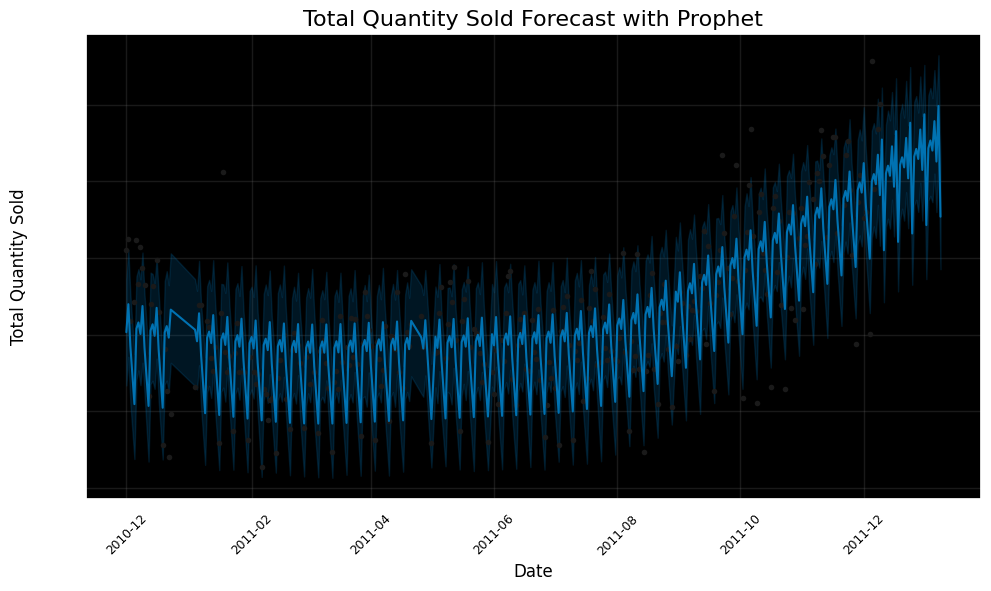

Prophet Mean Absolute Error (MAE): 3697.00
Prophet Root Mean Squared Error (RMSE): 4846.90


In [ ]:
df_prophet = daily_sales.reset_index()  # Reset index to convert the index (date) into a column

# Rename the relevant columns to 'ds' (date) and 'y' (Total_Quantity_Sold)
df_prophet = df_prophet[['Date', 'Total_Quantity_Sold']]  # Select relevant columns
df_prophet.columns = ['ds', 'y']  # Rename columns for Prophet

# Initialize the Prophet model
model = Prophet()

# Fit the model to the data
model.fit(df_prophet)

# Create a DataFrame to hold predictions for the next 30 days
future = model.make_future_dataframe(periods=30)

# Make predictions
forecast = model.predict(future)

# Plot the results
plt.style.use('dark_background')
fig = model.plot(forecast)
plt.title('Total Quantity Sold Forecast with Prophet', fontsize=16, color='black')
plt.xlabel('Date', fontsize=12, color='black')
plt.ylabel('Total Quantity Sold', fontsize=12, color='black')
plt.xticks(rotation=45, color='black')
plt.tight_layout()
plt.show()

# Evaluate the model
forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
actual_values = df_prophet['y'].values[-30:]

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, forecasted_values['yhat'].values)
rmse = mean_squared_error(actual_values, forecasted_values['yhat'].values, squared=False)

# Print evaluation metrics
print(f"Prophet Mean Absolute Error (MAE): {mae:.2f}")
print(f"Prophet Root Mean Squared Error (RMSE): {rmse:.2f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbp8p7cy/tolhd_ma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbp8p7cy/z7uhijh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25246', 'data', 'file=/tmp/tmpbbp8p7cy/tolhd_ma.json', 'init=/tmp/tmpbbp8p7cy/z7uhijh8.json', 'output', 'file=/tmp/tmpbbp8p7cy/prophet_model6n3s44gf/prophet_model-20241011173050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


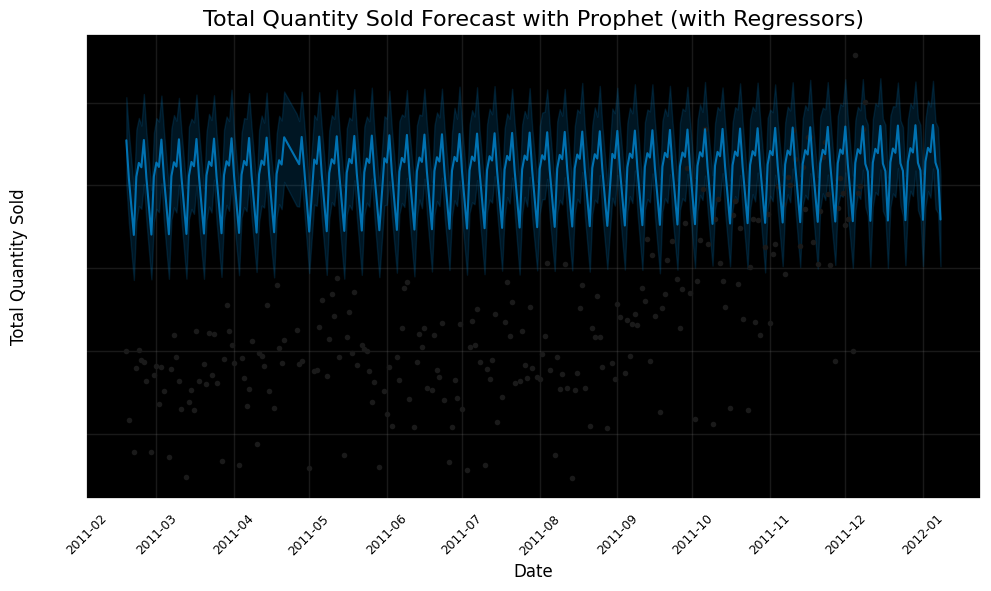

Prophet Mean Absolute Error (MAE): 3590.99
Prophet Root Mean Squared Error (RMSE): 4813.23


In [ ]:
#Create a DataFrame suitable for Prophet
df_prophet = data.reset_index()  # Reset index to convert the index (date) into a column

# Rename the relevant columns to 'ds' (date) and 'y' (Total_Quantity_Sold)
df_prophet = df_prophet[['Date', 'Total_Quantity_Sold', 'Lag_1', 'Lag_7', 'Moving_Avg_7']]  # Adjust columns based on your features
df_prophet.columns = ['ds', 'y', 'Lag_1', 'Lag_7', 'Moving_Avg_7']

# Initialize the Prophet model
model = Prophet()

# Add external regressors (your engineered features)
model.add_regressor('Lag_1')
model.add_regressor('Lag_7')
model.add_regressor('Moving_Avg_7')

# Fit the model to the data
model.fit(df_prophet)

# Create a DataFrame to hold predictions for the next 30 days
future = model.make_future_dataframe(periods=30)

# You must add future values for your regressors (this step is crucial)
# Assuming that for forecasting you are using the last available value for simplicity
future['Lag_1'] = df_prophet['Lag_1'].values[-1]  # Adjust accordingly
future['Lag_7'] = df_prophet['Lag_7'].values[-1]  # Adjust accordingly
future['Moving_Avg_7'] = df_prophet['Moving_Avg_7'].values[-1]  # Adjust accordingly

# Make predictions
forecast = model.predict(future)

# Plot the results
plt.style.use('dark_background')
fig = model.plot(forecast)
plt.title('Total Quantity Sold Forecast with Prophet (with Regressors)', fontsize=16, color='black')
plt.xlabel('Date', fontsize=12, color='black')
plt.ylabel('Total Quantity Sold', fontsize=12, color='black')
plt.xticks(rotation=45, color='black')
plt.tight_layout()
plt.show()

# Evaluate the model
forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
actual_values = df_prophet['y'].values[-30:]

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, forecasted_values['yhat'].values)
rmse = mean_squared_error(actual_values, forecasted_values['yhat'].values, squared=False)

print(f"Prophet Mean Absolute Error (MAE): {mae:.2f}")
print(f"Prophet Root Mean Squared Error (RMSE): {rmse:.2f}")


## Historical Data Method

Historical Data Method Mean Absolute Error (MAE): 2720.50
Historical Data Method Root Mean Squared Error (RMSE): 3411.46


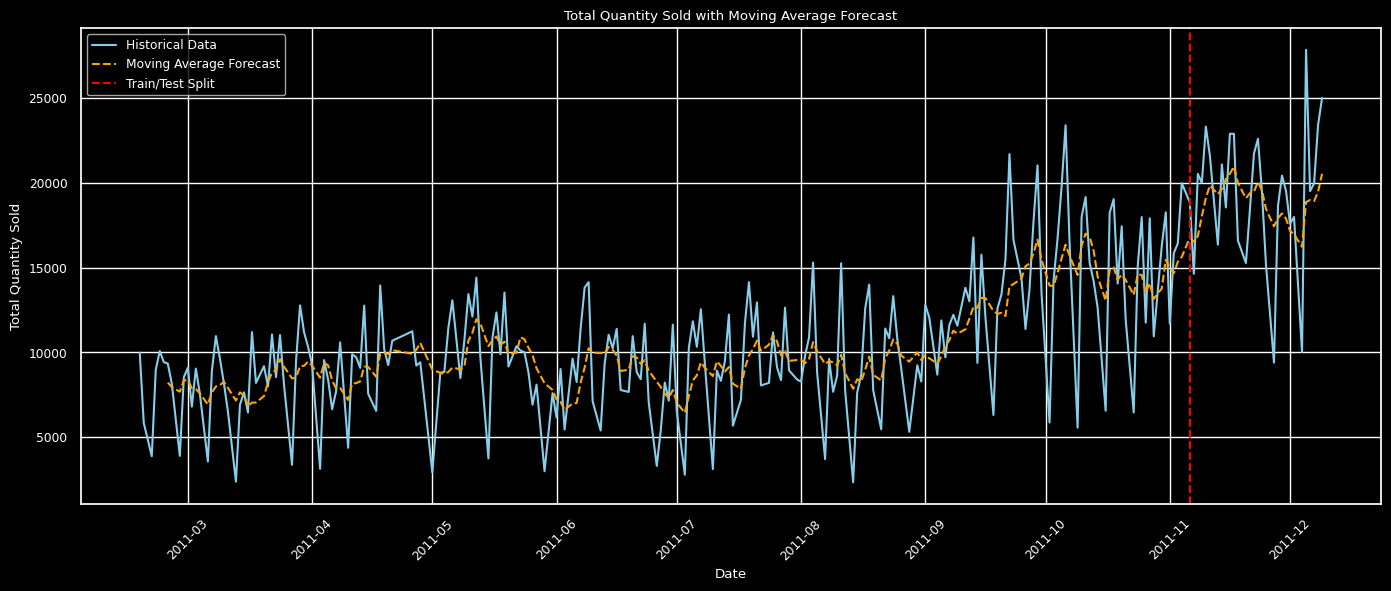

In [ ]:
# Create a new DataFrame for the historical data method
historical_sales = data.copy()
# Calculate the moving average for 'Total_Quantity_Sold'
window_size = 7  # Adjust the window size as needed
historical_sales['Forecast'] = historical_sales['Total_Quantity_Sold'].rolling(window=window_size).mean()

# Split into training and testing sets (80% train, 20% test)
train_size = len(historical_sales) - 30  # Last 30 days for testing
train_data = historical_sales[:train_size]
test_data = historical_sales[train_size:]

# Evaluate the forecast against the test set
actual_values = test_data['Total_Quantity_Sold'].values
predicted_values = test_data['Forecast'].values

# Calculate evaluation metrics
mae_historical = mean_absolute_error(actual_values, predicted_values)
rmse_historical = mean_squared_error(actual_values, predicted_values, squared=False)

# Print evaluation metrics
print(f"Historical Data Method Mean Absolute Error (MAE): {mae_historical:.2f}")
print(f"Historical Data Method Root Mean Squared Error (RMSE): {rmse_historical:.2f}")

# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(historical_sales.index, historical_sales['Total_Quantity_Sold'], label='Historical Data', color='skyblue')
plt.plot(historical_sales.index, historical_sales['Forecast'], label='Moving Average Forecast', color='orange', linestyle='--')
plt.title('Total Quantity Sold with Moving Average Forecast')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.axvline(x=historical_sales.index[train_size], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
class ModelEvaluator:
    def __init__(self):
        # Try to load existing metrics from a file
        try:
            self.metrics_df = pd.read_csv('metrics.csv')
        except FileNotFoundError:
            self.metrics_df = pd.DataFrame(columns=['Description', 'Model', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)'])

    def add_metrics(self, model_name, mae, rmse, description):
        # Check if the exact description and model combination already exists in the DataFrame
        if not self.metrics_df[(self.metrics_df['Description'] == description) & (self.metrics_df['Model'] == model_name)].empty:
            print(f"Metrics for model '{model_name}' with description '{description}' already exists. Metrics not added.")
            return

        # Create a DataFrame for the new metrics
        new_metrics = pd.DataFrame({
            'Description': [description],
            'Model': [model_name],
            'Mean Absolute Error (MAE)': [mae],
            'Root Mean Squared Error (RMSE)': [rmse]
        })

        # Append new metrics to the existing DataFrame
        self.metrics_df = pd.concat([self.metrics_df, new_metrics], ignore_index=True)
        # Save to CSV
        self.metrics_df.to_csv('metrics.csv', index=False)

    def drop_by_description(self, description):
        # Drop rows with the specified description
        self.metrics_df = self.metrics_df[self.metrics_df['Description'] != description]
        # Save updated metrics to CSV
        self.metrics_df.to_csv('metrics.csv', index=False)

    def display_metrics(self):
        # Display the summary table with better formatting
        display(self.metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')
                .set_table_styles([{
                    'selector': 'th',
                    'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('font-weight', 'bold')]
                }, {
                    'selector': 'td',
                    'props': [('border', '1px solid #ddd'), ('padding', '8px')]
                }])
                .set_properties(**{'text-align': 'left'})
               )

    def plot_metrics(self):
        # Group by description and plot metrics separately
        grouped = self.metrics_df.groupby('Description')

        for description, group in grouped:
            plt.figure(figsize=(10, 5))
            bar_width = 0.35
            index = range(len(group))

            # Bar plot for MAE
            plt.bar(index, group['Mean Absolute Error (MAE)'], bar_width, label='MAE', alpha=0.6, color='skyblue')
            # Bar plot for RMSE, offset to the right
            plt.bar([i + bar_width for i in index], group['Root Mean Squared Error (RMSE)'], bar_width, label='RMSE', alpha=0.6, color='orange')

            plt.title(f'Model Evaluation Metrics: {description}')
            plt.xlabel('Model')
            plt.ylabel('Error Value')
            plt.xticks([i + bar_width / 2 for i in index], group['Model'], rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()


In [ ]:
# Initialize the evaluator [ONLY ONCE]
evaluator = ModelEvaluator()

In [ ]:
# Add metrics for different models
evaluator.add_metrics('ARIMA', mae_arima , rmse_arima, 'After 1st feature engineering')
evaluator.add_metrics('STL Exponential Smoothing', mae_stl, rmse_stl, 'After 1st feature engineering')
evaluator.add_metrics('Prophet', mae, rmse, 'After 1st feature engineering')
evaluator.add_metrics('Linear Regression', mae_lr, rmse_lr, 'After 1st feature engineering')
evaluator.add_metrics('Historical Data Method', mae_historical, rmse_historical, 'After 1st feature engineering')
evaluator.add_metrics('XGBoost', mae_xgb, rmse_xgb, 'After 1st feature engineering')




,Description,Model,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Before feature engineering,ARIMA,3430.733684,4660.321295
1,Before feature engineering,STL Exponential Smoothing,2885.224440,3740.564504
2,Before feature engineering,Prophet,3696.995593,4846.895748
3,Before feature engineering,Linear Regression,6685.329085,7530.255558
4,Before feature engineering,Historical Data Method,2720.501905,3411.459880
5,Before feature engineering,XGBoost,6990.494085,7712.253715
6,After 1st feature engineering,ARIMA,3402.158050,4647.631498
7,After 1st feature engineering,STL Exponential Smoothing,2278.843003,3164.729226
8,After 1st feature engineering,Prophet,3590.994902,4813.231162
9,After 1st feature engineering,Linear Regression,6685.329085,7530.255558


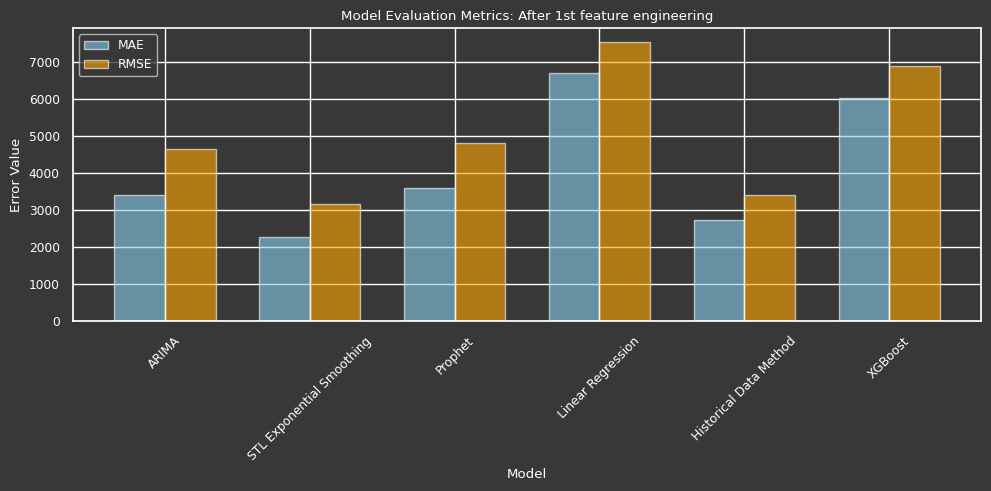

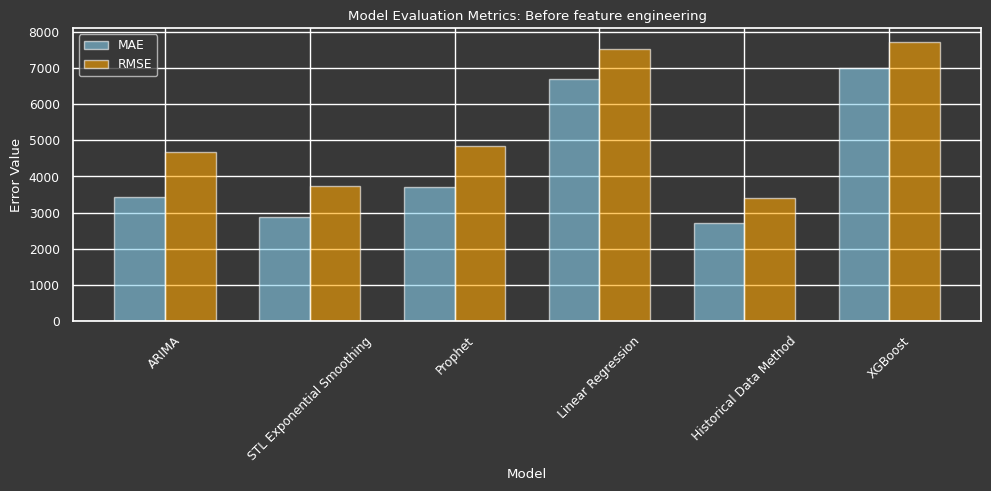

In [ ]:
evaluator.display_metrics()
evaluator.plot_metrics()

In [ ]:
evaluator.drop_by_description("Before feature engineering")

**INITIAL RESULTS**

Looking at the results, it’s clear that our best-performing model is the **Historical Data Method**, which has a lower Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) compared to the **STL Exponential Smoothing** model. This indicates that the Historical Data Method effectively captures the underlying patterns in the data.

On the other hand, **Linear Regression** shows the highest error metrics, suggesting it’s not performing as well.

To improve our models, I propose focusing on the following steps:

1. **Feature Engineering**: We should add lag features and account for seasonality and trends.

2. **Hyperparameter Tuning**: Optimizing hyperparameters for our models can lead to better performance.

3. **Explore Advanced Models**: Testing models like LSTM or XGBoost could yield improved results.

4. **Ensemble Methods**: Combining predictions from different models may enhance accuracy.

5. **Residual Analysis**: Visualizing residuals will help us ensure our models are not missing important relationships.

By implementing these steps, I believe we can significantly enhance our model performance moving forward.




**AFTER 1ST FEATURE ENGINEERING ATTEMPT**


The best-performing model is STL Exponential Smoothing, both before and after feature engineering, with significant reductions in MAE (from 2885.22 to 2278.84) and RMSE (from 3740.56 to 3164.73).

ARIMA shows slight improvement after feature engineering, but it’s still outperformed by STL.

XGBoost improves significantly after feature engineering, but it remains less effective than STL and ARIMA.

Linear Regression and the Historical Data Method don’t benefit from feature engineering, with Linear Regression showing the worst performance overall.

In summary, STL Exponential Smoothing is the best option, especially after feature engineering.


# Conclusion